# Stakeholder Conflicts: Balancing Different Goals

This notebook demonstrates how to handle **conflicting stakeholder goals** in prescriptive models.

Understanding stakeholder conflicts helps you:
- Model different stakeholder objectives
- Show how solutions balance conflicting goals
- Demonstrate what happens when one stakeholder is ignored
- Find compromise solutions acceptable to all stakeholders


## Key Concepts

**Stakeholder Conflicts** occur when different groups want different things:
- Operations wants cost efficiency
- Marketing wants visibility and reach
- HR wants employee satisfaction
- Finance wants profit maximization

**Why This Matters:**
- Models that optimize for one stakeholder ignore others
- Ignored stakeholders reject recommendations
- Balanced solutions are more likely to be accepted

**Critical insight**: Models must balance all stakeholders' goals. Optimizing for one stakeholder while ignoring others leads to recommendations that get rejected.


## Scenario: Facility Location Decision

A retail chain is deciding where to open a new distribution center. Three stakeholder groups have different goals:

**Operations** wants to minimize cost:
- Prefer locations with low land costs
- Prefer locations with good logistics access
- Goal: Minimize total operational cost

**Marketing** wants to maximize visibility:
- Prefer locations in high-traffic areas
- Prefer locations with good signage opportunities
- Goal: Maximize visibility score

**HR** wants to maximize employee accessibility:
- Prefer locations with good public transportation
- Prefer locations near amenities
- Goal: Maximize accessibility score

These goals conflict: Low-cost locations might have poor visibility. High-visibility locations might be expensive.

**Decision**: Which location balances all three stakeholder goals?


## Step 1: Install Required Packages (Colab)


In [1]:
# Install pulp package (required for optimization)
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpMaximize, LpProblem, LpVariable, lpSum, value


## Step 3: Define Location Options and Stakeholder Goals

Set up the facility location problem:


In [3]:
# Available locations
locations = ['Location A', 'Location B', 'Location C', 'Location D']
n_locations = len(locations)

# Location characteristics (scores normalized 0-100)
location_data = {
    'Location A': {'cost': 2.5, 'visibility': 60, 'accessibility': 70},  # Low cost, medium visibility, good access
    'Location B': {'cost': 4.0, 'visibility': 90, 'accessibility': 50},  # High cost, high visibility, poor access
    'Location C': {'cost': 3.0, 'visibility': 75, 'accessibility': 80},  # Medium cost, good visibility, excellent access
    'Location D': {'cost': 2.0, 'visibility': 50, 'accessibility': 60}   # Very low cost, low visibility, medium access
}

print("LOCATION DATA")
print("=" * 70)
df = pd.DataFrame(location_data).T
df.columns = ['Cost ($M/year)', 'Visibility Score', 'Accessibility Score']
display(df)

print("\nSTAKEHOLDER GOALS:")
print("  Operations: Minimize cost")
print("  Marketing: Maximize visibility")
print("  HR: Maximize accessibility")


LOCATION DATA


,Cost ($M/year),Visibility Score,Accessibility Score
Location A,2.5,60.0,70.0
Location B,4.0,90.0,50.0
Location C,3.0,75.0,80.0
Location D,2.0,50.0,60.0



STAKEHOLDER GOALS:
  Operations: Minimize cost
  Marketing: Maximize visibility
  HR: Maximize accessibility


## Step 4: Optimize for Each Stakeholder Separately

First, let's see what happens when we optimize for each stakeholder individually:


In [4]:
# Optimize for Operations (minimize cost)
model_ops = LpProblem("Operations_Only", LpMinimize)
select_ops = [LpVariable(f"select_ops_{i}", cat='Binary') for i in range(n_locations)]
model_ops += lpSum([select_ops[i] for i in range(n_locations)]) == 1  # Select exactly one
total_cost_ops = lpSum([location_data[locations[i]]['cost'] * select_ops[i] for i in range(n_locations)])
model_ops += total_cost_ops
model_ops.solve()
ops_location = [locations[i] for i in range(n_locations) if value(select_ops[i]) > 0.5][0]
ops_cost = value(total_cost_ops)
ops_vis = sum([location_data[locations[i]]['visibility'] * value(select_ops[i]) for i in range(n_locations)])
ops_acc = sum([location_data[locations[i]]['accessibility'] * value(select_ops[i]) for i in range(n_locations)])

# Optimize for Marketing (maximize visibility)
model_mkt = LpProblem("Marketing_Only", LpMaximize)
select_mkt = [LpVariable(f"select_mkt_{i}", cat='Binary') for i in range(n_locations)]
model_mkt += lpSum([select_mkt[i] for i in range(n_locations)]) == 1
total_vis_mkt = lpSum([location_data[locations[i]]['visibility'] * select_mkt[i] for i in range(n_locations)])
model_mkt += total_vis_mkt
model_mkt.solve()
mkt_location = [locations[i] for i in range(n_locations) if value(select_mkt[i]) > 0.5][0]
mkt_cost = sum([location_data[locations[i]]['cost'] * value(select_mkt[i]) for i in range(n_locations)])
mkt_vis = value(total_vis_mkt)
mkt_acc = sum([location_data[locations[i]]['accessibility'] * value(select_mkt[i]) for i in range(n_locations)])

# Optimize for HR (maximize accessibility)
model_hr = LpProblem("HR_Only", LpMaximize)
select_hr = [LpVariable(f"select_hr_{i}", cat='Binary') for i in range(n_locations)]
model_hr += lpSum([select_hr[i] for i in range(n_locations)]) == 1
total_acc_hr = lpSum([location_data[locations[i]]['accessibility'] * select_hr[i] for i in range(n_locations)])
model_hr += total_acc_hr
model_hr.solve()
hr_location = [locations[i] for i in range(n_locations) if value(select_hr[i]) > 0.5][0]
hr_cost = sum([location_data[locations[i]]['cost'] * value(select_hr[i]) for i in range(n_locations)])
hr_vis = sum([location_data[locations[i]]['visibility'] * value(select_hr[i]) for i in range(n_locations)])
hr_acc = value(total_acc_hr)

print("OPTIMIZING FOR EACH STAKEHOLDER SEPARATELY")
print("=" * 70)
results = pd.DataFrame({
    'Stakeholder': ['Operations', 'Marketing', 'HR'],
    'Selected Location': [ops_location, mkt_location, hr_location],
    'Cost ($M/year)': [ops_cost, mkt_cost, hr_cost],
    'Visibility Score': [ops_vis, mkt_vis, hr_vis],
    'Accessibility Score': [ops_acc, mkt_acc, hr_acc]
})
display(results)

print("\nObservations:")
print("  - Operations chooses Location D (lowest cost, but poor visibility)")
print("  - Marketing chooses Location B (highest visibility, but high cost and poor access)")
print("  - HR chooses Location C (best access, but medium cost and visibility)")
print("  - Each stakeholder gets what they want, but others are ignored")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/808dab5581dd45d7817b9ac6ff97d0e9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/808dab5581dd45d7817b9ac6ff97d0e9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 23 RHS
At line 25 BOUNDS
At line 30 ENDATA
Problem MODEL has 1 rows, 4 columns and 4 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of w

,Stakeholder,Selected Location,Cost ($M/year),Visibility Score,Accessibility Score
0,Operations,Location D,2.0,50.0,60.0
1,Marketing,Location B,4.0,90.0,50.0
2,HR,Location C,3.0,75.0,80.0



Observations:
  - Operations chooses Location D (lowest cost, but poor visibility)
  - Marketing chooses Location B (highest visibility, but high cost and poor access)
  - HR chooses Location C (best access, but medium cost and visibility)
  - Each stakeholder gets what they want, but others are ignored


In [5]:
# Balanced model: minimize weighted combination of deviations
model_balanced = LpProblem("Balanced_Stakeholders", LpMinimize)

select_bal = [LpVariable(f"select_bal_{i}", cat='Binary') for i in range(n_locations)]
model_balanced += lpSum([select_bal[i] for i in range(n_locations)]) == 1

# Calculate actual values
cost_bal = lpSum([location_data[locations[i]]['cost'] * select_bal[i] for i in range(n_locations)])
vis_bal = lpSum([location_data[locations[i]]['visibility'] * select_bal[i] for i in range(n_locations)])
acc_bal = lpSum([location_data[locations[i]]['accessibility'] * select_bal[i] for i in range(n_locations)])

# Deviation variables (normalized)
# For cost: want to minimize, so deviation is cost - min_cost
min_cost = min([location_data[loc]['cost'] for loc in locations])
max_cost = max([location_data[loc]['cost'] for loc in locations])
cost_dev = (cost_bal - min_cost) / (max_cost - min_cost + 0.001)

# For visibility: want to maximize, so deviation is max_vis - visibility
max_vis = max([location_data[loc]['visibility'] for loc in locations])
min_vis = min([location_data[loc]['visibility'] for loc in locations])
vis_dev = (max_vis - vis_bal) / (max_vis - min_vis + 0.001)

# For accessibility: want to maximize, so deviation is max_acc - accessibility
max_acc = max([location_data[loc]['accessibility'] for loc in locations])
min_acc = min([location_data[loc]['accessibility'] for loc in locations])
acc_dev = (max_acc - acc_bal) / (max_acc - min_acc + 0.001)

# Objective: minimize weighted sum of normalized deviations
weight_ops = 1.0
weight_mkt = 1.0
weight_hr = 1.0
model_balanced += weight_ops * cost_dev + weight_mkt * vis_dev + weight_hr * acc_dev

model_balanced.solve()

bal_location = [locations[i] for i in range(n_locations) if value(select_bal[i]) > 0.5][0]
bal_cost = value(cost_bal)
bal_vis = value(vis_bal)
bal_acc = value(acc_bal)

print("BALANCED SOLUTION (All Stakeholders)")
print("=" * 70)
print(f"Selected Location: {bal_location}")
print(f"  Cost: ${bal_cost:.2f}M/year")
print(f"  Visibility: {bal_vis:.0f}")
print(f"  Accessibility: {bal_acc:.0f}")

# Compare to individual optimizations
comparison = pd.DataFrame({
    'Approach': ['Operations Only', 'Marketing Only', 'HR Only', 'Balanced'],
    'Location': [ops_location, mkt_location, hr_location, bal_location],
    'Cost ($M)': [ops_cost, mkt_cost, hr_cost, bal_cost],
    'Visibility': [ops_vis, mkt_vis, hr_vis, bal_vis],
    'Accessibility': [ops_acc, mkt_acc, hr_acc, bal_acc]
})

print("\nCOMPARISON: Individual vs Balanced")
print("=" * 70)
display(comparison)

print("\nKey Insights:")
print("  - Balanced solution doesn't optimize for any single stakeholder")
print("  - But it's acceptable to all stakeholders")
print("  - Individual optimizations ignore other stakeholders' goals")
print("  - Balanced solutions are more likely to be accepted and implemented")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0466856bd0544b5ba2e88a639e26c307-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0466856bd0544b5ba2e88a639e26c307-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 23 RHS
At line 25 BOUNDS
At line 30 ENDATA
Problem MODEL has 1 rows, 4 columns and 4 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -3.04228 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -3.04228 to -1.79769e+308
Probing was tried 0 times and creat

,Approach,Location,Cost ($M),Visibility,Accessibility
0,Operations Only,Location D,2.0,50.0,60.0
1,Marketing Only,Location B,4.0,90.0,50.0
2,HR Only,Location C,3.0,75.0,80.0
3,Balanced,Location C,3.0,75.0,80.0



Key Insights:
  - Balanced solution doesn't optimize for any single stakeholder
  - But it's acceptable to all stakeholders
  - Individual optimizations ignore other stakeholders' goals
  - Balanced solutions are more likely to be accepted and implemented


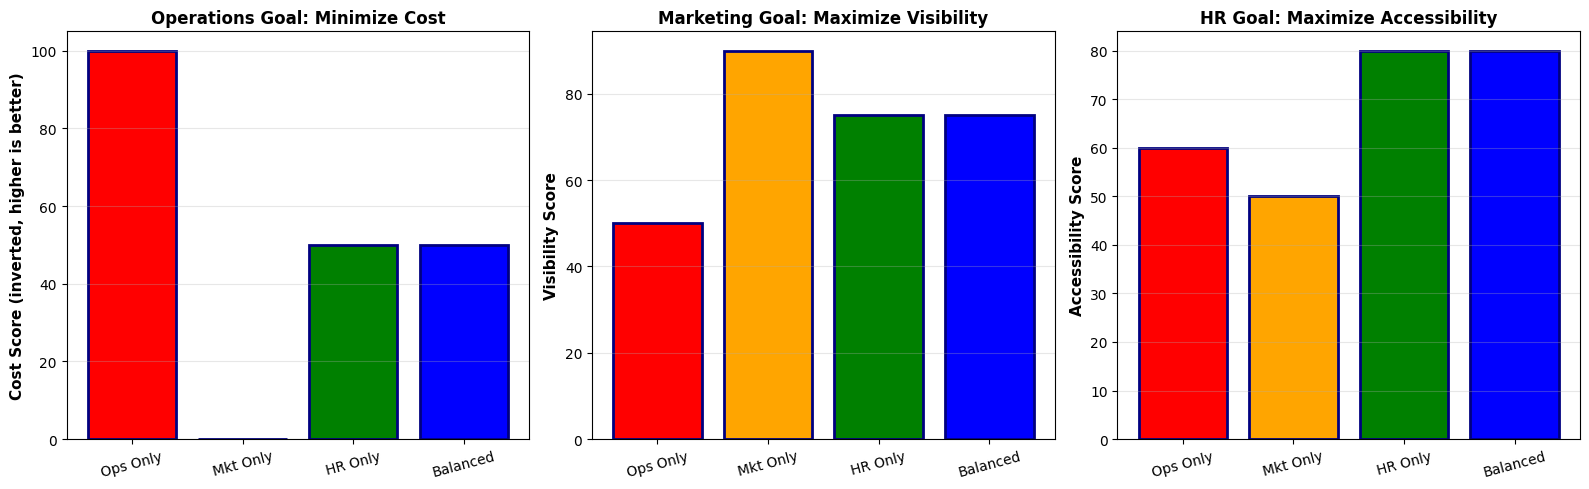


Key Observations:
  - Each individual optimization excels in one area but fails in others
  - Balanced solution performs reasonably well across all goals
  - No stakeholder gets everything, but all get something acceptable
  - This is the essence of compromise in stakeholder conflicts


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

approaches = ['Ops Only', 'Mkt Only', 'HR Only', 'Balanced']
costs = [ops_cost, mkt_cost, hr_cost, bal_cost]
visibilities = [ops_vis, mkt_vis, hr_vis, bal_vis]
accessibilities = [ops_acc, mkt_acc, hr_acc, bal_acc]

# Normalize for visualization (0-100 scale)
max_cost_val = max(costs)
min_cost_val = min(costs)
costs_norm = [100 - (c - min_cost_val) / (max_cost_val - min_cost_val + 0.001) * 100 for c in costs]

# Plot 1: Operations perspective (cost - lower is better, so invert)
axes[0].bar(approaches, costs_norm, color=['red', 'orange', 'green', 'blue'], edgecolor='navy', linewidth=2)
axes[0].set_ylabel('Cost Score (inverted, higher is better)', fontsize=11, fontweight='bold')
axes[0].set_title('Operations Goal: Minimize Cost', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Plot 2: Marketing perspective (visibility - higher is better)
axes[1].bar(approaches, visibilities, color=['red', 'orange', 'green', 'blue'], edgecolor='navy', linewidth=2)
axes[1].set_ylabel('Visibility Score', fontsize=11, fontweight='bold')
axes[1].set_title('Marketing Goal: Maximize Visibility', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

# Plot 3: HR perspective (accessibility - higher is better)
axes[2].bar(approaches, accessibilities, color=['red', 'orange', 'green', 'blue'], edgecolor='navy', linewidth=2)
axes[2].set_ylabel('Accessibility Score', fontsize=11, fontweight='bold')
axes[2].set_title('HR Goal: Maximize Accessibility', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Each individual optimization excels in one area but fails in others")
print("  - Balanced solution performs reasonably well across all goals")
print("  - No stakeholder gets everything, but all get something acceptable")
print("  - This is the essence of compromise in stakeholder conflicts")


## Summary: Understanding Stakeholder Conflicts

**Stakeholder Conflicts** require balanced solutions:
- Different stakeholders want different things
- Optimizing for one stakeholder ignores others
- Balanced solutions are more likely to be accepted

**Key Takeaways**:
- Models must consider all stakeholders' goals
- Compromise is necessary when goals conflict
- Balanced solutions don't optimize for any single stakeholder
- Understanding stakeholder conflicts helps build models that produce acceptable recommendations
